In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math as m
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout, Flatten
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
URL_dataset = pd.read_csv("/content/malicious_phish.csv")
URL_dataset.head(10)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [ ]:
import numpy as np
import pandas as pd
import math as m
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout, Flatten
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install whois
!pip install pyquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import keras
import sklearn
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("sklearn version", sklearn.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0
sklearn version 1.6.1


In [ ]:
import math

class FeatureExtractor:
    def __init__(self, url=""):
        self.url = url
        self.domain = url.split('//')[-1].split('/')[0]

    def url_entropy(self):
        url_trimmed = self.url.strip()
        entropy_distribution = [float(url_trimmed.count(c)) / len(url_trimmed) for c in dict.fromkeys(list(url_trimmed))]
        return -sum([e * math.log(e, 2) for e in entropy_distribution if e > 0])

    def digits_num(self):
        return len([i for i in self.url if i.isdigit()])

    def length(self):
        return len(self.url)

    def params_num(self):
        return len(self.url.split('&')) - 1

    def fragments_num(self):
        return len(self.url.split('#')) - 1

    def subdomain_num(self):
        return len(self.domain.split('.')) - 1

    def dom_ext(self):
        return self.domain.split('.')[-1]

    def has_http(self):
        return 'http' in self.url

    def has_https(self):
        return 'https' in self.url

    def is_ip(self):
        parts = self.domain.split('.')
        if len(parts) == 4 and all(part.isdigit() and 0 <= int(part) <= 255 for part in parts):
            return True
        return False

    def run(self):
        return {
            "url": self.url,
            "entropy": self.url_entropy(),
            "digits": self.digits_num(),
            "url_length": self.length(),
            "param_nums": self.params_num(),
            "fragment_nums": self.fragments_num(),
            "subdomain_nums": self.subdomain_num(),
            "domain_extension": self.dom_ext(),
            "has_http": self.has_http(),
            "has_https": self.has_https(),
            "is_ip": self.is_ip(),
            "num_%20" : self.url.count("%20"),
            "num_@" : self.url.count("@")
        }

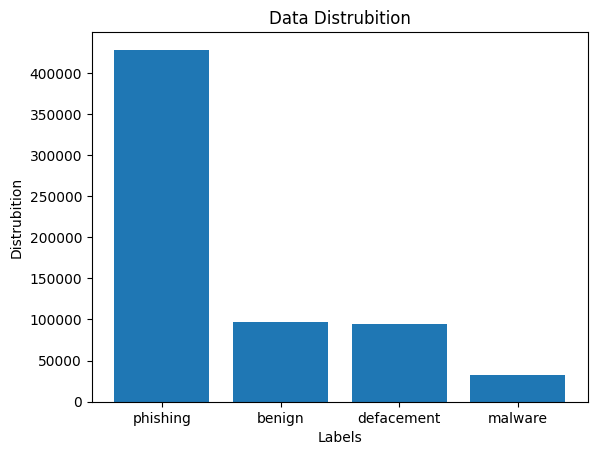

In [ ]:
url = pd.read_csv(
    "/content/malicious_phish.csv"
)
counts = url["type"].value_counts()
plt.bar(url["type"].unique(),counts)
plt.title('Data Distrubition')
plt.xlabel('Labels')
plt.ylabel('Distrubition')
plt.show()

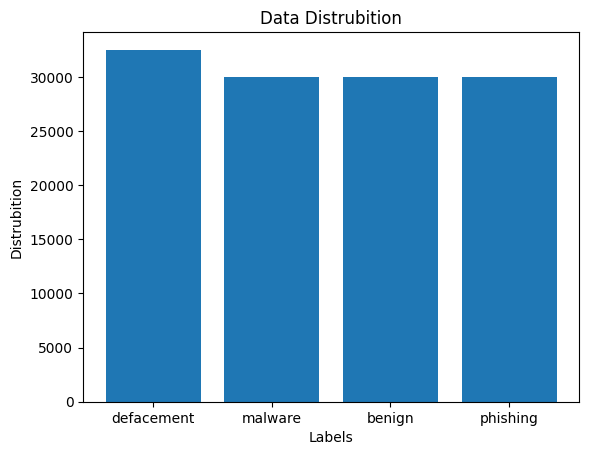

In [ ]:
benign = url[url['type'] == 'benign']
malware = url[url['type'] == 'malware']
defacement = url[url['type'] == 'defacement']
phishing = url[url['type'] == 'phishing']

benign_downsampled = benign.sample(n=30000, random_state=55)
phishing_downsampled = phishing.sample(n=30000, random_state=55)
defacement_downsampled = defacement.sample(n=30000, random_state=55)

balanced_df = pd.concat([benign_downsampled, malware, defacement_downsampled, phishing_downsampled])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

plt.bar(balanced_df["type"].unique(),balanced_df['type'].value_counts())
plt.title('Data Distrubition')
plt.xlabel('Labels')
plt.ylabel('Distrubition')
plt.show()

In [ ]:
from tqdm import tqdm
features = []
for url in tqdm(balanced_df['url']):
    features.append(FeatureExtractor(url).run())
print(len(features))
features_df = pd.DataFrame(features)

100%|██████████| 122520/122520 [00:04<00:00, 26451.91it/s]


122520


In [ ]:
features_df["type"] = balanced_df["type"]
features_df.head(5)

,url,entropy,digits,url_length,param_nums,fragment_nums,subdomain_nums,domain_extension,has_http,has_https,is_ip,num_%20,num_@,type
0,http://dhc-sport.com/index2.php?option=com_vir...,4.655775,6,116,5,0,1,com,True,False,False,0,0,defacement
1,http://945wg.com/news/index.html?list_39_2.html,4.434819,6,47,0,0,1,com,True,False,False,0,0,defacement
2,http://9779.info/%E8%8E%B7%E5%A5%96%E6%A0%91%E...,3.911454,31,90,0,0,1,info,True,False,False,0,0,malware
3,http://aawsc.xyz/chrome.apk,4.032303,0,27,0,0,1,xyz,True,False,False,0,0,malware
4,http://www.poly-murau.at/index.php?option=com_...,4.630443,4,82,3,0,2,at,True,False,False,0,0,defacement


In [ ]:
features_df = features_df.dropna(subset=['type'])
features_df.head()
features_df["type"].value_counts()

,count
type,
malware,32520
defacement,30000
benign,30000
phishing,30000


In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(features_df["url"])
sequences = tokenizer.texts_to_sequences(features_df['url'])
max_len = 100
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
print("done")

done


In [ ]:
label_encoder = LabelEncoder()


features_df['type'] = label_encoder.fit_transform(features_df['type'])

y = to_categorical(features_df['type'], num_classes=4)
y

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [ ]:
extra_features = features_df[['entropy', 'digits', 'url_length', 'param_nums',
                       'has_http', 'has_https', 'is_ip',
                       'num_%20', 'num_@']].astype(np.int32).values
labels = features_df['type'].astype(np.int32).values

In [ ]:
url_input = Input(shape=(100,), name="url_input")
embedding = Embedding(input_dim=256, output_dim=64)(url_input)
lstm_out = LSTM(64, return_sequences=False)(embedding)

features_input = Input(shape=(9,), name="extra_features")
dense_features = Dense(32, activation="relu")(features_input)

merged = Concatenate()([lstm_out, dense_features])
dense1 = Dense(64, activation="relu")(merged)
dropout = Dropout(0.5)(dense1)
output = Dense(4, activation="softmax", name="output")(dropout)


model = Model(inputs=[url_input, features_input], outputs=output)


model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ url_input           │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 64)   │     16,384 │ url_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_features      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     33,024 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        320 │ extra_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 4)         │        260 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,196 (219.52 KB)

 Trainable params: 56,196 (219.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train_seq, X_test_seq, X_train_extra, X_test_extra, y_train, y_test = train_test_split(
    padded_sequences, extra_features, y, test_size=0.3, random_state=42
)

In [ ]:
url_input = Input(shape=(100,), name="url_input")

vocab_size = len(tokenizer.word_index) + 1

embedding = Embedding(input_dim=vocab_size, output_dim=64)(url_input)
lstm_out = LSTM(64, return_sequences=False)(embedding)

features_input = Input(shape=(9,), name="extra_features")
dense_features = Dense(32, activation="relu")(features_input)

merged = Concatenate()([lstm_out, dense_features])
dense1 = Dense(64, activation="relu")(merged)
dropout = Dropout(0.5)(dense1)
output = Dense(4, activation="softmax", name="output")(dropout)

model = Model(inputs=[url_input, features_input], outputs=output)

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ url_input           │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 64)   │  8,502,144 │ url_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_features      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     33,024 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        320 │ extra_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      6,208 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 4)         │        260 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,541,956 (32.58 MB)

 Trainable params: 8,541,956 (32.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    [X_train_seq, X_train_extra], y_train,
    epochs=10,
    batch_size=32,
    validation_data=([X_test_seq, X_test_extra], y_test),
    verbose=1
)

Epoch 1/10
2681/2681 ━━━━━━━━━━━━━━━━━━━━ 453s 169ms/step - accuracy: 0.5532 - loss: 1.0391 - val_accuracy: 0.6697 - val_loss: 0.7385
Epoch 2/10
2681/2681 ━━━━━━━━━━━━━━━━━━━━ 497s 167ms/step - accuracy: 0.6605 - loss: 0.8071 - val_accuracy: 0.6903 - val_loss: 0.7056
Epoch 3/10
2681/2681 ━━━━━━━━━━━━━━━━━━━━ 503s 168ms/step - accuracy: 0.6661 - loss: 0.7792 - val_accuracy: 0.7037 - val_loss: 0.7039
Epoch 4/10
2681/2681 ━━━━━━━━━━━━━━━━━━━━ 500s 167ms/step - accuracy: 0.6786 - loss: 0.7571 - val_accuracy: 0.6968 - val_loss: 0.6810
Epoch 5/10
2681/2681 ━━━━━━━━━━━━━━━━━━━━ 500s 166ms/step - accuracy: 0.6780 - loss: 0.7428 - val_accuracy: 0.7075 - val_loss: 0.6736
Epoch 6/10
2681/2681 ━━━━━━━━━━━━━━━━━━━━ 448s 167ms/step - accuracy: 0.6870 - loss: 0.7226 - val_accuracy: 0.6925 - val_loss: 0.6666
Epoch 7/10
2681/2681 ━━━━━━━━━━━━━━━━━━━━ 446s 166ms/step - accuracy: 0.6916 - loss: 0.7074 - val_accuracy: 0.7193 - val_loss: 0.6389
Epoch 8/10
2681/2681 ━━━━━━━━━━━━━━━━━━━━ 446s 166ms/step - ac

In [ ]:
import numpy as np

y_pred_probs = model.predict([X_test_seq, X_test_extra])

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


1149/1149 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print("🔍 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

print(f"✅ Accuracy Score: {accuracy_score(y_true, y_pred):.4f}")


🔍 Classification Report:
              precision    recall  f1-score   support

           0     0.9287    0.8431    0.8838      8851
           1     0.9965    0.9924    0.9944      9068
           2     0.9913    0.9425    0.9663      9797
           3     0.8241    0.9458    0.8808      9040

    accuracy                         0.9317     36756
   macro avg     0.9351    0.9309    0.9313     36756
weighted avg     0.9364    0.9317    0.9323     36756

✅ Accuracy Score: 0.9317


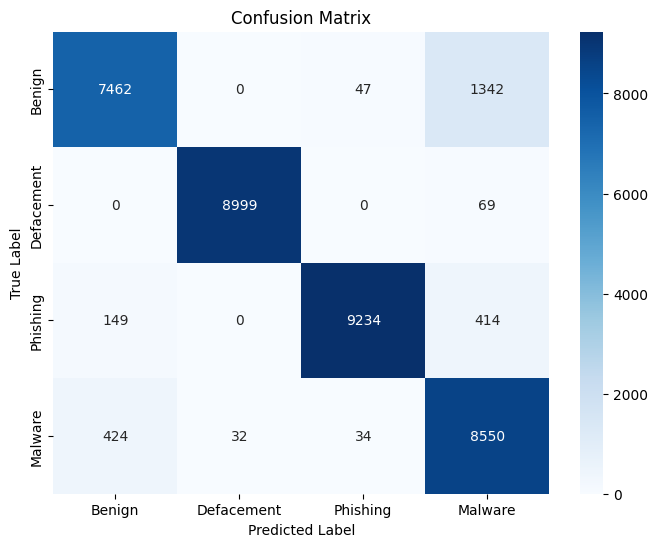

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
labels = ['Benign', 'Defacement', 'Phishing', 'Malware']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
print(f"🎯 ROC-AUC Score (OvR): {roc_auc:.4f}")


🎯 ROC-AUC Score (OvR): 0.9907


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd


In [ ]:
X = balanced_df['url']
y = balanced_df['type']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

In [ ]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM (Linear)": SVC(kernel='linear', probability=True)
}

results = {}

for name, model in models.items():
    print(f"\n🔍 Training {name}...")
    model.fit(X_train_m, y_train_m)
    y_pred_m = model.predict(X_test_m)

    acc = accuracy_score(y_test_m, y_pred_m)
    print(f"✅ Accuracy: {acc:.4f}")
    print(classification_report(y_test_m, y_pred_m, target_names=le.classes_))

    # Save results
    results[name] = acc



🔍 Training Decision Tree...
✅ Accuracy: 0.9223
              precision    recall  f1-score   support

      benign       0.91      0.85      0.88      5843
  defacement       0.97      0.98      0.98      6089
     malware       0.98      0.97      0.97      6567
    phishing       0.83      0.88      0.85      6005

    accuracy                           0.92     24504
   macro avg       0.92      0.92      0.92     24504
weighted avg       0.92      0.92      0.92     24504


🔍 Training Random Forest...
✅ Accuracy: 0.9305
              precision    recall  f1-score   support

      benign       0.92      0.86      0.89      5843
  defacement       0.97      0.99      0.98      6089
     malware       0.99      0.97      0.98      6567
    phishing       0.84      0.90      0.87      6005

    accuracy                           0.93     24504
   macro avg       0.93      0.93      0.93     24504
weighted avg       0.93      0.93      0.93     24504


🔍 Training SVM (Linear)...
✅ Accu

In [ ]:
dl_acc = 0.945

results["CNN-LSTM (DL Model)"] = dl_acc

print("\n📊 Model Accuracy Comparison:")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")



📊 Model Accuracy Comparison:
Decision Tree: 0.9223
Random Forest: 0.9305
SVM (Linear): 0.9189
CNN-LSTM (DL Model): 0.9450


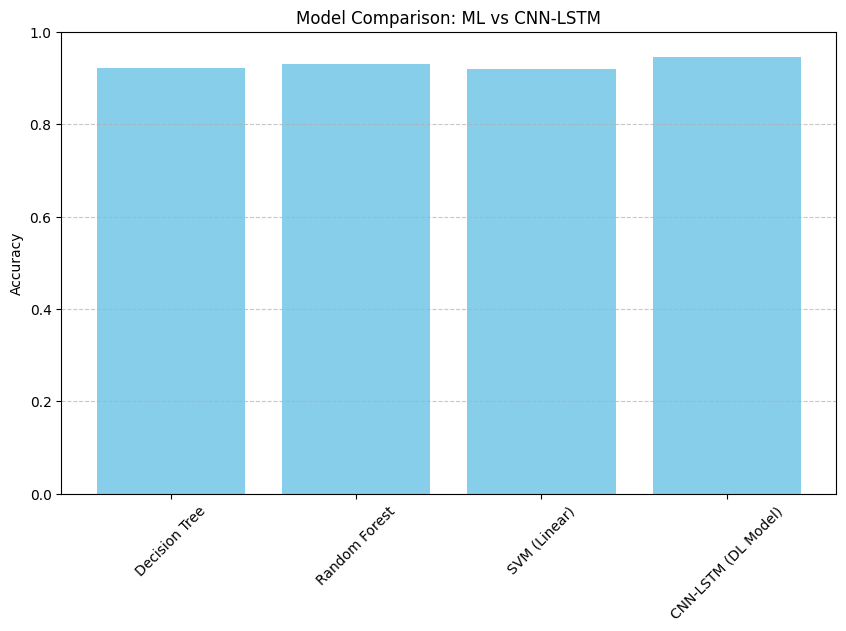

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel("Accuracy")
plt.title("Model Comparison: ML vs CNN-LSTM")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
df=pd.read_csv('malicious_phish.csv')

print(df.shape)
df.head()

(45288, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
df.type.value_counts()

,count
type,
benign,33231
defacement,8269
phishing,2698
malware,1089


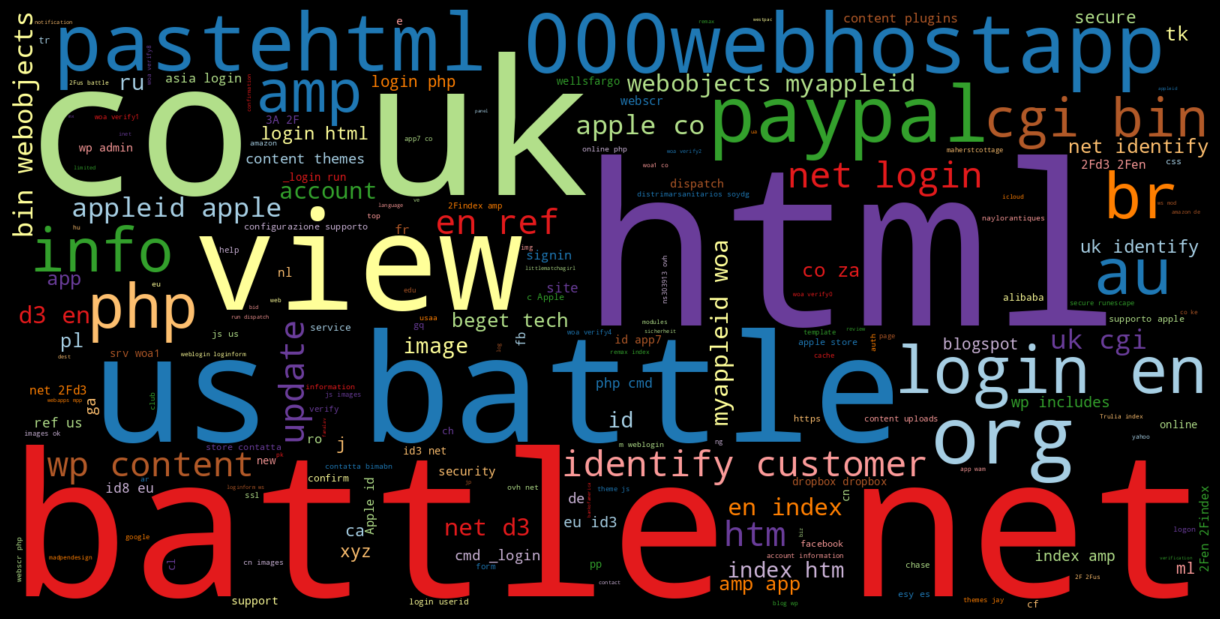

In [ ]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(phish_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

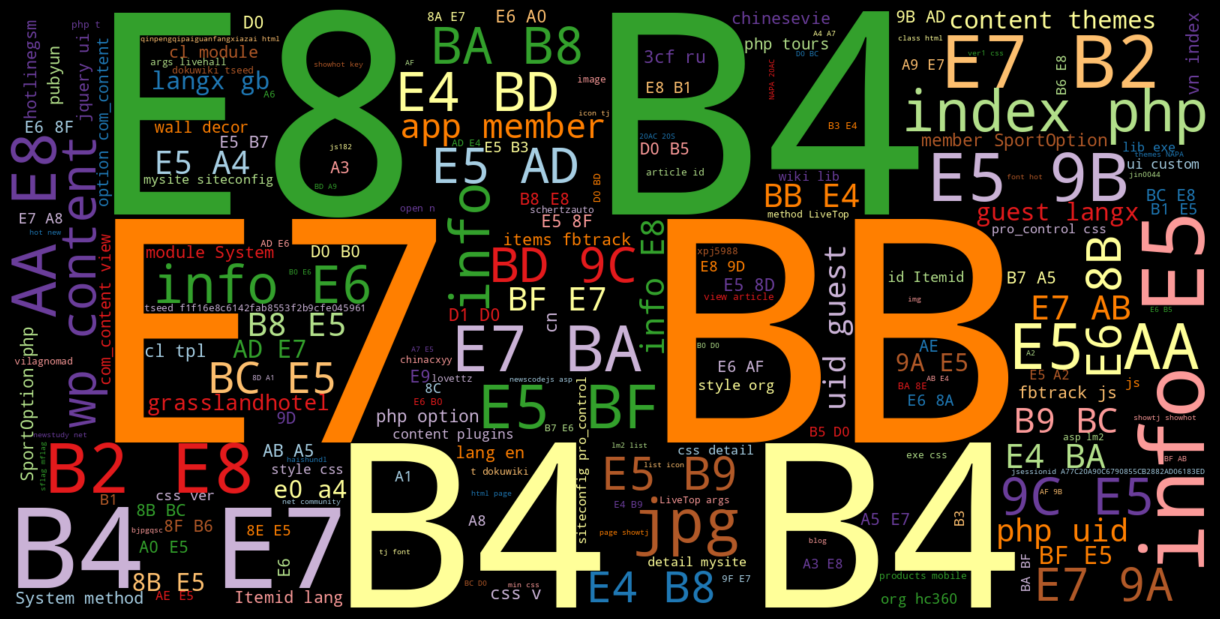

In [ ]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

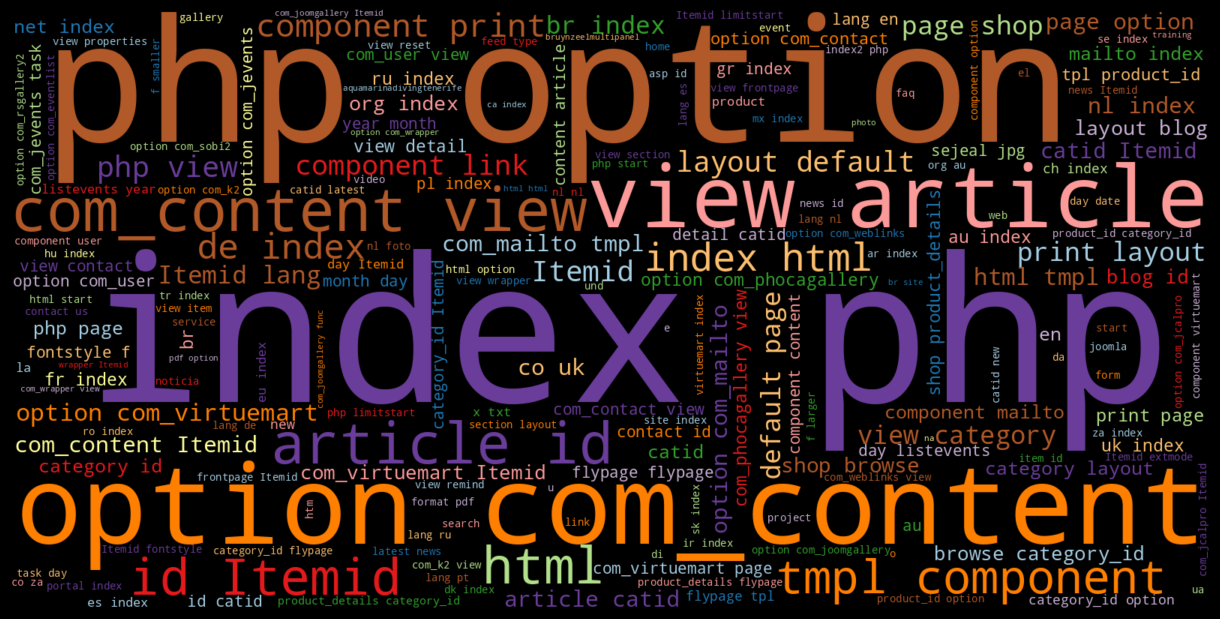

In [ ]:
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

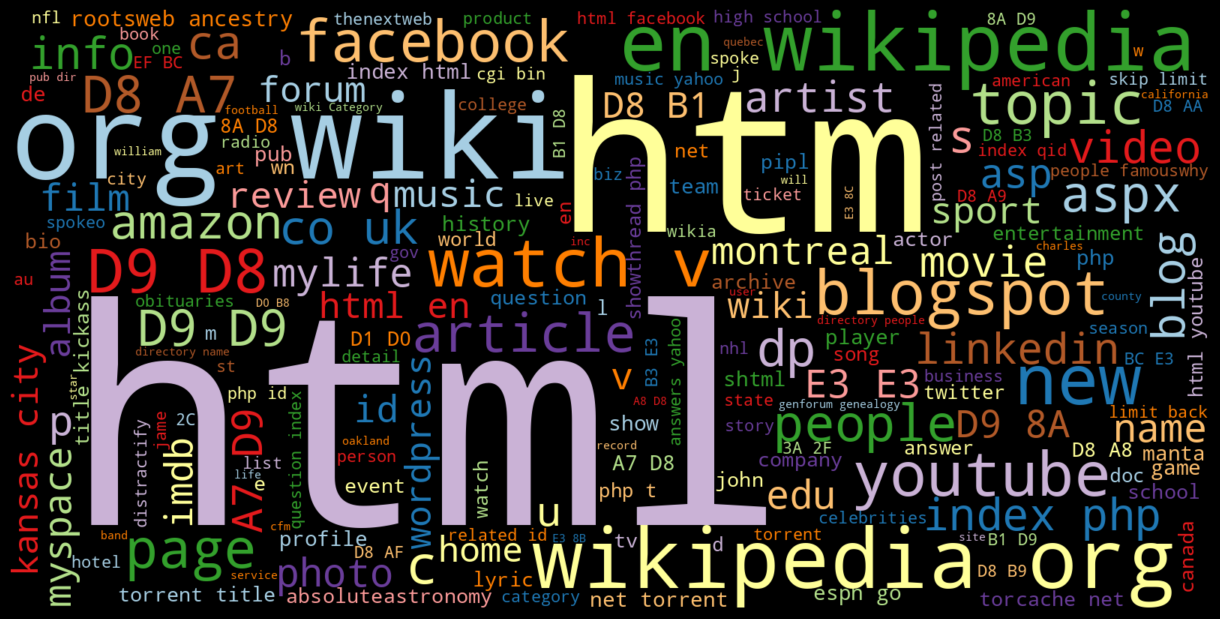

In [ ]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
import re
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [ ]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [ ]:
from googlesearch import search
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [ ]:
def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):

    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))


def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0


df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [ ]:
def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))


In [ ]:
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))


df['url_length'] = df['url'].apply(lambda i: url_length(i))


def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


df['count-letters']= df['url'].apply(lambda i: letter_count(i))

df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,0,0,1,0,16,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,0,0,0,35,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,0,0,0,31,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,0,1,1,4,88,21,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,0,1,1,3,235,23,0,22,199


In [ ]:
!pip install tld
from urllib.parse import urlparse
from tld import get_tld
import os.path

def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 4.4 MB/s eta 0:00:00


In [ ]:
df = df.drop("tld", axis=1)

In [ ]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [ ]:
# benign        428103
# defacement     96457
# phishing       94111
# malware        32520
# # Name: type, dtype: int64 # This line is a comment and not executable code
# malware        32520
# Name: type, dtype: int64
# malware        32520
# Name: type, dtype: int64 # This line is a comment and not executable code
# malware        32520
# Name: type, dtype: int64 # Comment out the lines that caused the error

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
    accuracy_score
)

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/content/malicious_phish.csv')

label_encoder = LabelEncoder()
df['label_enc'] = label_encoder.fit_transform(df['type'])


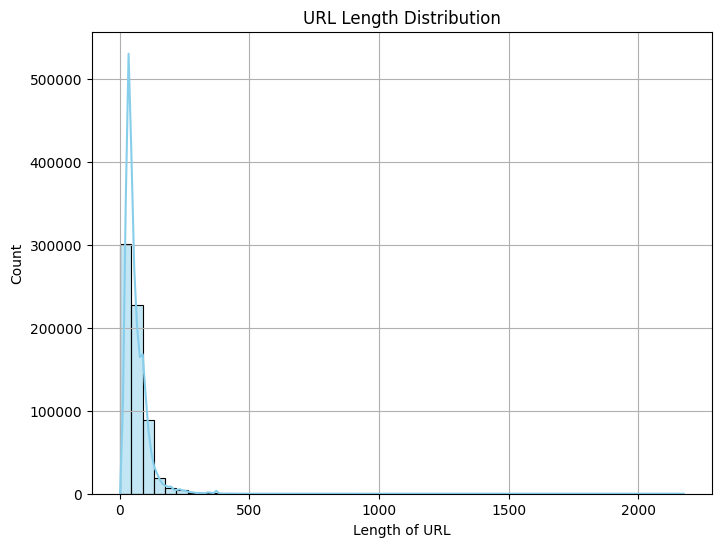

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(df['url'].apply(len), bins=50, kde=True, color='skyblue')
plt.title('URL Length Distribution')
plt.xlabel('Length of URL')
plt.ylabel('Count')
plt.grid(True)
plt.show()


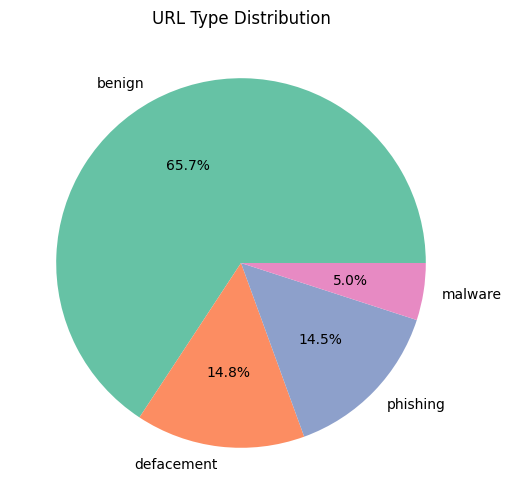

In [ ]:
plt.figure(figsize=(6,6))
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('URL Type Distribution')
plt.ylabel('')
plt.show()


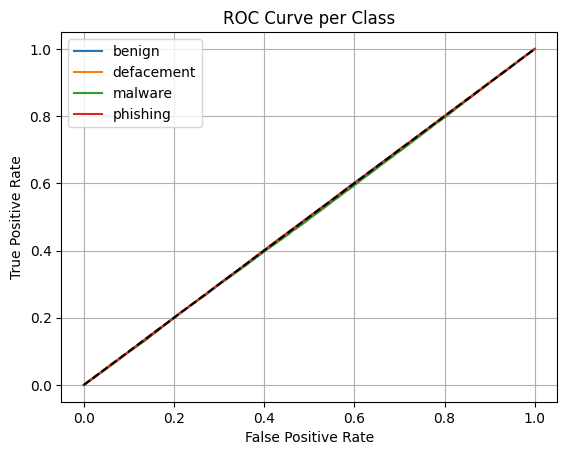

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
    accuracy_score
)

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/content/malicious_phish.csv')

label_encoder = LabelEncoder()
df['label_enc'] = label_encoder.fit_transform(df['type'])

y_true = df['label_enc']

y_bin = label_binarize(y_true, classes=np.unique(y_true))

y_pred_dl = np.random.rand(len(y_true), len(np.unique(y_true)))

for i in range(4):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_pred_dl[:, i])
    plt.plot(fpr, tpr, label=label_encoder.classes_[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve per Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

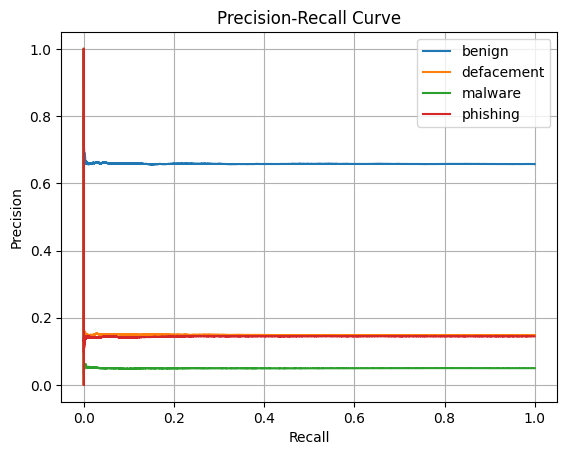

In [ ]:
y_bin = label_binarize(y_true, classes=[0,1,2,3])
for i in range(4):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], y_pred_dl[:, i])
    plt.plot(recall, precision, label=label_encoder.classes_[i])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


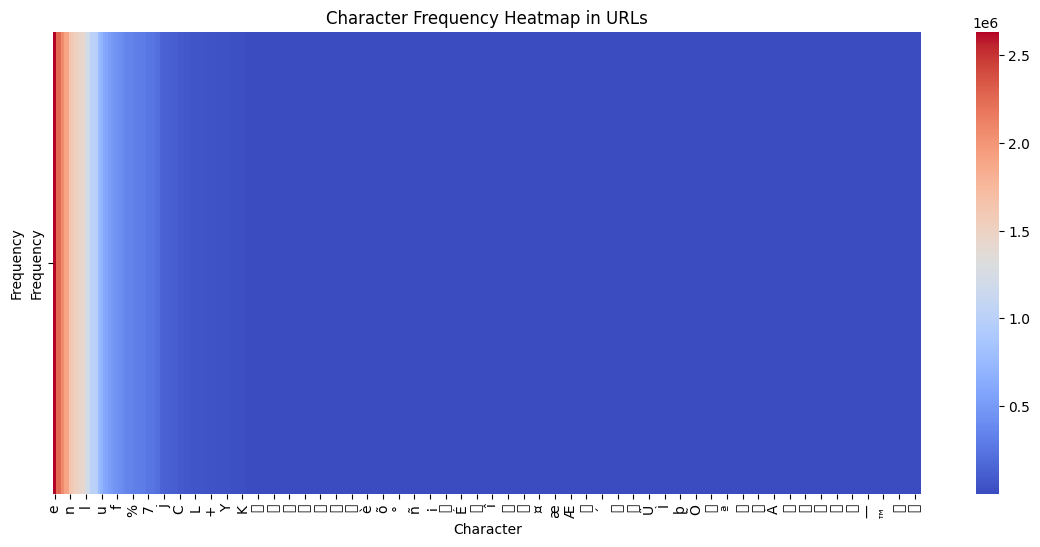

In [ ]:
from collections import Counter

all_chars = ''.join(df['url'].values)
char_counts = Counter(all_chars)
char_freq_df = pd.DataFrame.from_dict(char_counts, orient='index').sort_values(by=0, ascending=False)
char_freq_df.columns = ['Frequency']

plt.figure(figsize=(14,6))
sns.heatmap(char_freq_df.T, cmap="coolwarm", cbar=True)
plt.title("Character Frequency Heatmap in URLs")
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()


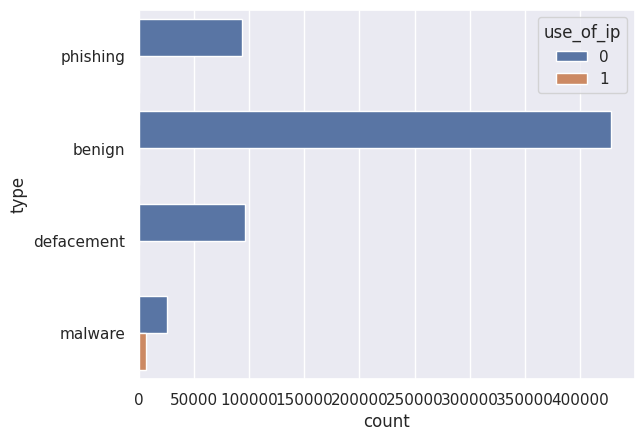

In [4]:
import seaborn as sns
import pandas as pd

df = pd.read_csv('malicious_phish.csv')

import re
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)'
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)
    if match:
        return 1
    else:
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))


sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df, hue="use_of_ip")

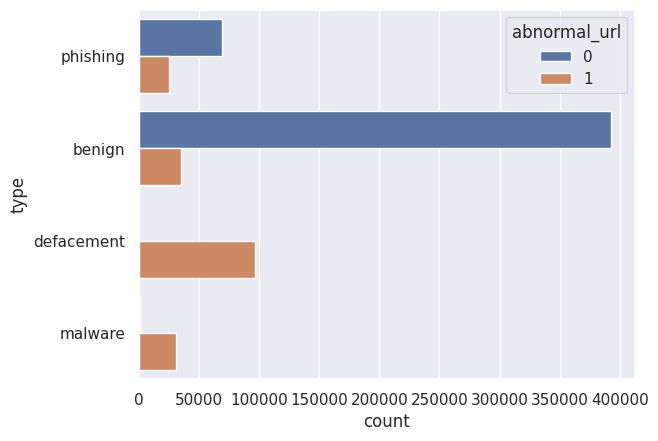

In [9]:
import seaborn as sns
import pandas as pd
import re

df = pd.read_csv('malicious_phish.csv')

def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
df['use_of_ip'] = df['url'].apply(lambda url: having_ip_address(url))

from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0

df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="abnormal_url")

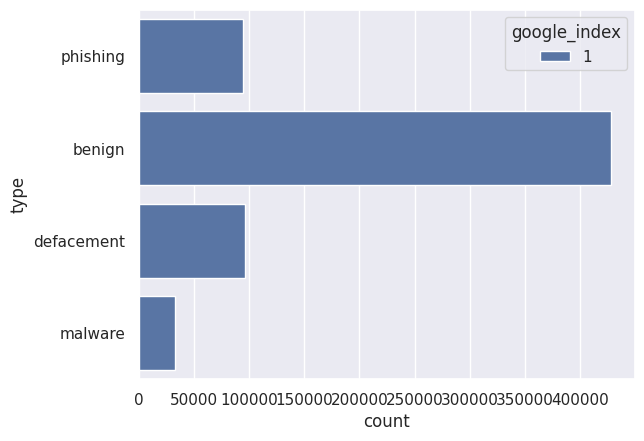

In [11]:
import seaborn as sns
import pandas as pd
import re

df = pd.read_csv('malicious_phish.csv')

def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
df['use_of_ip'] = df['url'].apply(lambda url: having_ip_address(url))

from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0

df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

from googlesearch import search
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))


sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="google_index")

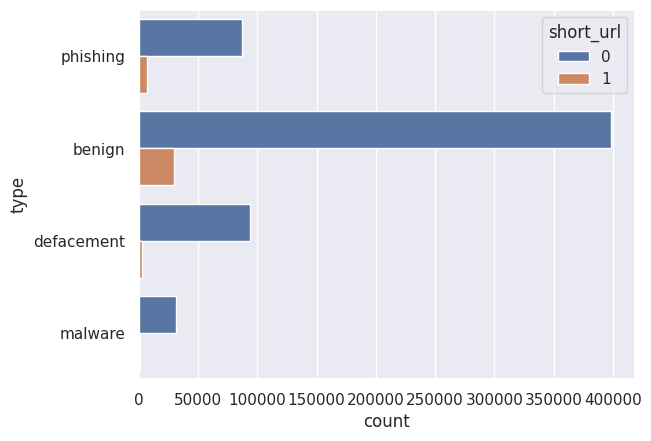

In [13]:
import seaborn as sns
import pandas as pd
import re

df = pd.read_csv('malicious_phish.csv')

def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df, hue="short_url")

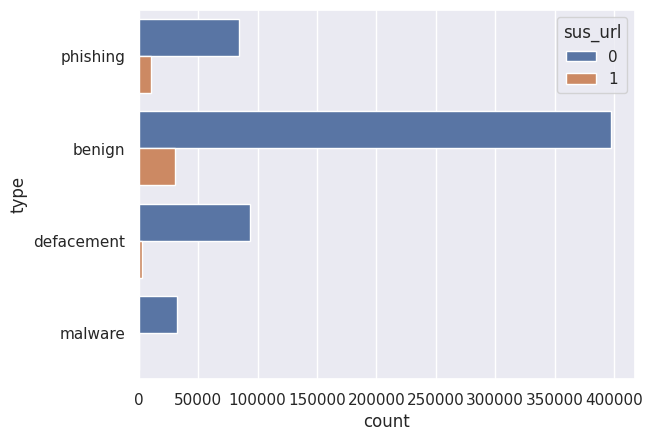

In [15]:
import seaborn as sns
import pandas as pd
import re

df = pd.read_csv('malicious_phish.csv')

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))

sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="sus_url")

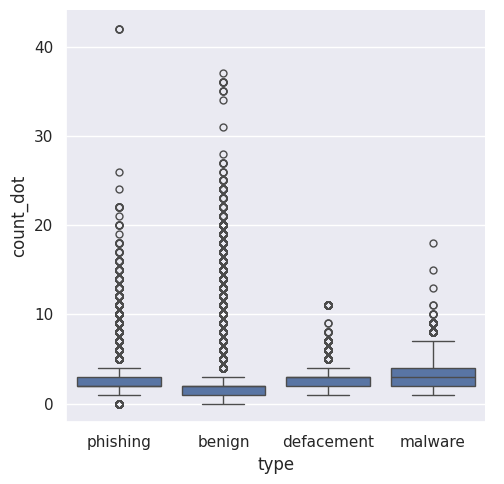

In [22]:
import seaborn as sns
import pandas as pd
import re

df = pd.read_csv('malicious_phish.csv')

def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count_dot'] = df['url'].apply(lambda i: count_dot(i))

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_dot", kind="box", data=df)

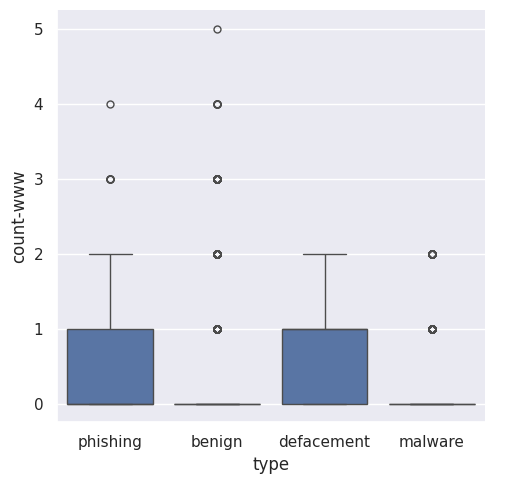

In [24]:
import seaborn as sns
import pandas as pd
import re

df = pd.read_csv('malicious_phish.csv')

def count_www(url):
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))


sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count-www", kind="box", data=df)

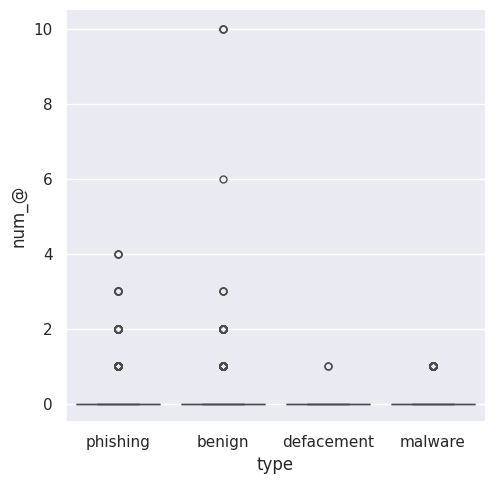

In [29]:
import seaborn as sns
import pandas as pd
import re

df = pd.read_csv('malicious_phish.csv')

df['num_@'] = df['url'].apply(lambda url: url.count('@'))

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="num_@", kind="box", data=df)

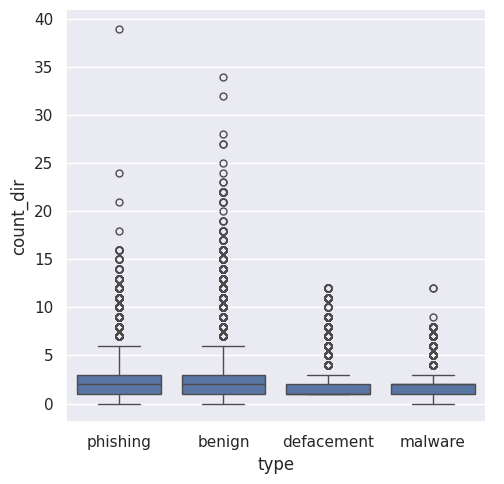

In [31]:
import seaborn as sns
import pandas as pd
import re
from urllib.parse import urlparse

df = pd.read_csv('malicious_phish.csv')

def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i)) # Calculate 'count_dir' before using it

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_dir", kind="box", data=df)

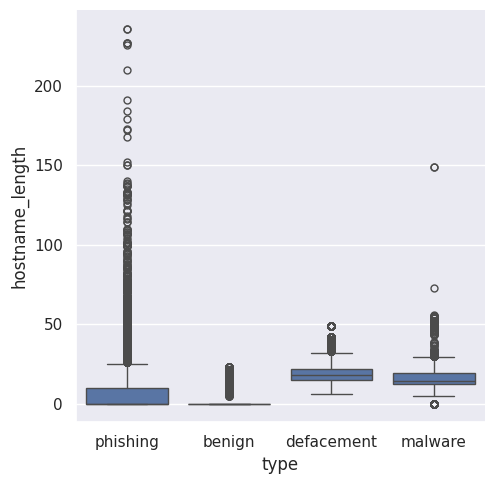

In [33]:
import seaborn as sns
import pandas as pd
import re
from urllib.parse import urlparse

df = pd.read_csv('malicious_phish.csv')

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=df)

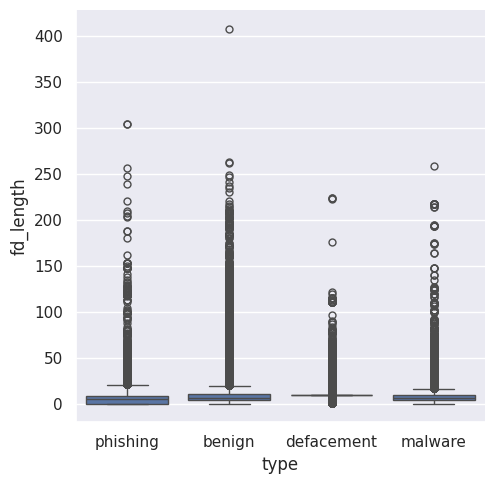

In [42]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="fd_length", kind="box", data=df)

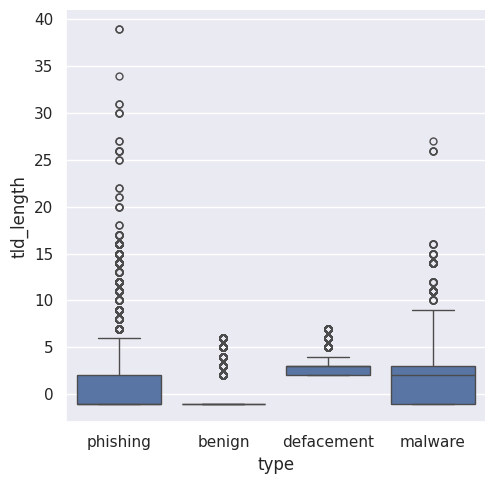

In [43]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="tld_length", kind="box", data=df)